# Visualizer
### Use this script to visualize the neuron traces according to the paper "A Generalized Linear Integrate-and-Fire Neural Model Produces Diverse Spiking Behaviors" by Stefan Mihalas and Ernst Niebur. Further, data was created with a fix length of 1sec (1ms time steps), with noise on the input current, and/or temporal jitter on the time point of the step for dynamic inputs. 

### The script will also calculate the inter-spike intervalls (ISIs) for a single trial and for all repeating trials, whenever possible. For repeating trials, all ISIs are grouped and further statics represent the outcome of all repetitions per class.

In [26]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import numpy.polynomial.polynomial as poly

from tactile_encoding.utils.utils import value2key, create_directory


In [27]:
max_trials = 100

classes_list = {
    'A': "Tonic spiking",
    'B': "Class 1",
    'C': "Spike frequency adaptation",
    'D': "Phasic spiking",
    'E': "Accommodation",
    'F': "Threshold variability",
    'G': "Rebound spike",
    'H': "Class 2",
    'I': "Integrator",
    'J': "Input bistability",
    'K': "Hyperpolarizing spiking",
    'L': "Hyperpolarizing bursting",
    'M': "Tonic bursting",
    'N': "Phasic bursting",
    'O': "Rebound burst",
    'P': "Mixed mode",
    'Q': "Afterpotentials",
    'R': "Basal bistability",
    'S': "Preferred frequency",
    'T': "Spike latency",
}


In [28]:
def return_isi_fix_len(data, max_trials, norm_count=False, norm_time=False):
    """
    Calculates and returns the ISI for all repetitions of fix length data.
    """
    isi_list = []
    for num, el in enumerate(list(classes_list.values())):
        # print(el)
        # concatenate all ISIs
        isi_fix_len = []
        for trial in range(max_trials):
            # calc spikes per trial
            spikes = np.reshape(np.array(data[trial + num*max_trials][0]), (np.array(
                data[trial + num*max_trials][0]).shape[0]))
            # calc ISI
            isi_fix_len.extend(np.diff(np.where(spikes == 1)[0]))

        if len(isi_fix_len) > 0:
            tmp_fix_len = np.unique(isi_fix_len, return_counts=True)
            isi_fix_len = tmp_fix_len[0]
            if norm_time:
                isi_fix_len = isi_fix_len/max(isi_fix_len)
            isi_fix_len_count = tmp_fix_len[1]
            if norm_count:
                isi_fix_len_count = isi_fix_len_count/max(isi_fix_len_count)
            # create 2d array
            isi = np.vstack([isi_fix_len, isi_fix_len_count])
        isi_list.append(isi)

    return isi_list

### NTE - Tactile encoding

In [29]:
import torch
import os

In [30]:
data_path_braille = './data/braille_mn_output'  # path to load data
data_path_original = './data/original_mn_output'
plot_out = './plots'
# neuron parameters
a: 2.743
A1: 0.03712
A2: -0.5089
b: 11.4
G: 47.02
k1: 200
k2: 20
R1: 0
R2: 1


In [31]:
# extract and concatenate all ISIs for each label and sensor over all data after training and test
file_names = os.listdir(data_path_braille)
file_names = np.sort(file_names)
isi_list = []
isi_dict = {}
for entry in range(27):
    isi_dict[entry] = []
for _, file_name in enumerate(file_names):
    [mn_spk, input_current, trial_label] = torch.load(
        data_path_braille + '/' + file_name, map_location=torch.device('cpu'))
    # convert to numpy
    mn_spk = mn_spk.numpy()
    input_current = input_current.numpy()
    trial_label = trial_label.numpy()

    # extract traces from single batch
    for batch in range(mn_spk.shape[0]):
        isi_list = []

        # loop over all channels
        for channel in range(mn_spk[batch].shape[-1]):
            # calc ISI per channel and append to list
            isi_list.append(np.diff(np.where(mn_spk[batch][:, channel] == 1.0))*1E-2)

        # init dict per label
        if len(isi_dict[trial_label[batch]]) < 1:
            isi_dict[trial_label[batch]] = isi_list
        # extend dict if contains already values
        else:
            # extend the dict for each channel
            for entry in range(len(isi_dict[trial_label[batch]])):
                if len(isi_list[entry]) > 0:
                    isi_dict[trial_label[batch]][entry] = np.append(isi_dict[trial_label[batch]][entry], isi_list[entry], axis=1)


KeyboardInterrupt: 

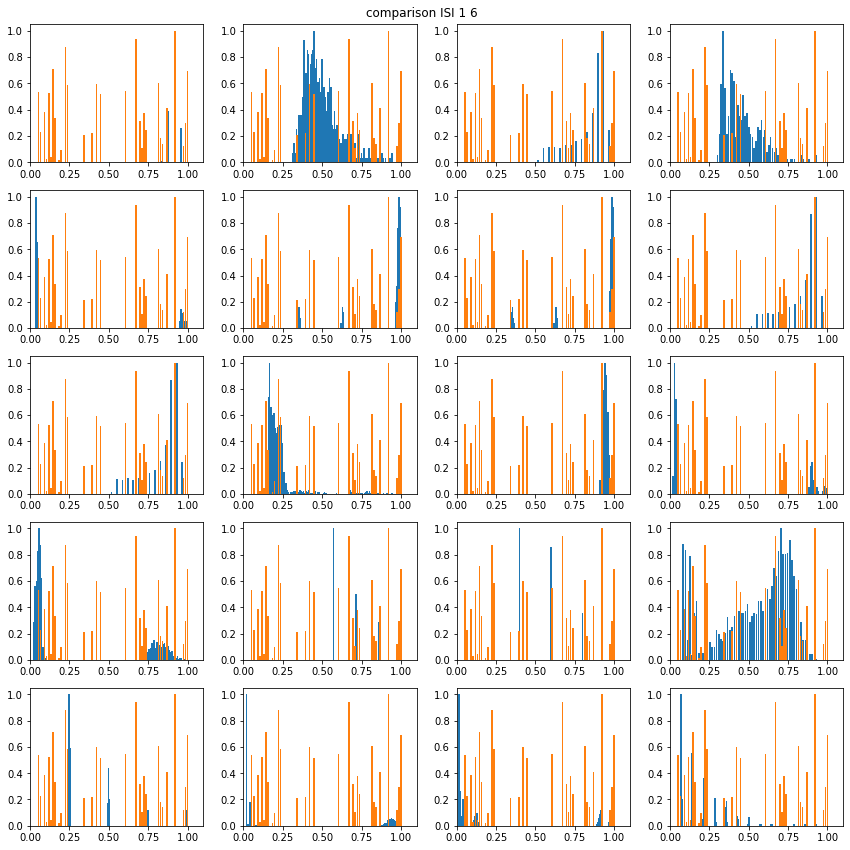

In [32]:
# load ISIs from paper
norm_count = True
norm_time = True
# data_types = ['', '_noisy', '_temp_jitter', '_noisy_temp_jitter']
filename = 'data_encoding_fix_len_noisy_temp_jitter'
infile = open(f"{data_path_original}/{filename}.pkl", 'rb')
data_original = pickle.load(infile)
infile.close()
isi_original = return_isi_fix_len(
    data_original, max_trials, norm_count=norm_count, norm_time=norm_time)

for _, entry in enumerate(isi_dict):
    # iterate over channel
    for channel in range(len(isi_dict[entry])):
        # extract single ISIs and their count
        isi, count = np.unique(isi_dict[entry][channel][0], return_index=True)

        # only plot if ISIs found in channel
        if len(isi) > 0:
            if norm_time:
                isi = isi/max(isi)
            if norm_count:
                count = count/max(count)

            figname = f'comparison ISI {entry} {channel}'
            plt.figure(figsize=(12, 12))
            plt.suptitle(figname)
            # compare to original traces
            for num, isi_original_sel in enumerate(isi_original):
                plt.subplot(5, 4, num+1)
                if norm_time:
                    plt.bar(isi_original_sel[0],
                            isi_original_sel[1], width=0.01)
                    plt.bar(isi, count, width=0.01)
                else:
                    plt.bar(isi_original_sel[0], isi_original_sel[1])
                    plt.bar(isi, count)
                plt.xlim((0, 1.1))
            plt.tight_layout()
            plt.savefig(
                f'{plot_out}/comparison_class_{entry}_channel_{channel}.png', dpi=300)
            plt.close()


<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.